In [1]:
from importlib import reload  
import pandas as pd
import clintraj_qi
reload(clintraj_qi)

from clintraj_qi import quantify_nans
from clintraj_qi import detect_variable_type
from clintraj_qi import quantify_dataframe_univariate
from clintraj_qi import SVDcomplete_imputation_method
from clintraj_qi import load_quantification_info
from clintraj_qi import invert_quant_info
from clintraj_qi import dequantify_table


In [2]:
# loading the table

file = 'data/infarction/all_dummies.txt'
df = pd.read_csv(file,delimiter='\t')
display(df)

,ID,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,SIM_GIPERT,DLIT_AG,...,REC_IM,P_IM_STEN,LET_IS_0,LET_IS_1,LET_IS_2,LET_IS_3,LET_IS_4,LET_IS_5,LET_IS_6,LET_IS_7
0,1,77.0,1,2.0,1.0,1.0,2.0,3.0,0.0,7.0,...,0,0.0,1,0,0,0,0,0,0,0
1,2,55.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,1,0,0,0,0,0,0,0
2,3,52.0,1,0.0,0.0,0.0,2.0,2.0,0.0,2.0,...,0,0.0,1,0,0,0,0,0,0,0
3,4,68.0,0,0.0,0.0,0.0,2.0,2.0,0.0,3.0,...,0,0.0,1,0,0,0,0,0,0,0
4,5,60.0,1,0.0,0.0,0.0,2.0,3.0,0.0,7.0,...,0,0.0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1569,1695,77.0,0,0.0,0.0,0.0,0.0,2.0,0.0,7.0,...,0,0.0,0,0,0,1,0,0,0,0
1570,1696,77.0,0,0.0,4.0,2.0,1.0,2.0,0.0,7.0,...,0,0.0,0,0,0,1,0,0,0,0
1571,1697,70.0,0,0.0,6.0,2.0,1.0,2.0,0.0,7.0,...,0,0.0,0,1,0,0,0,0,0,0
1572,1699,79.0,0,2.0,2.0,2.0,1.0,2.0,0.0,7.0,...,0,0.0,0,1,0,0,0,0,0,0


In [3]:
quantify_nans(df,file_to_write=file[:-4]+'_complete.txt')

Missing values 4780 (2.468982758442578%)
Number of complete rows: 533 (33.86277001270648%)


In [4]:
variable_types, binary, continuous, ordinal = detect_variable_type(df,10,verbose=False)
#correct_column_types_in_dataframe(df,variable_types)
#variable_types, binary, continuous, ordinal = detect_variable_type(df,10,verbose=True)
    
df[binary].to_csv(file[:-4]+'_binary.txt', index=False,sep='\t')
df[continuous].to_csv(file[:-4]+'_continuous.txt', index=False,sep='\t')
df[ordinal].to_csv(file[:-4]+'_ordinal.txt', index=False,sep='\t')

In [5]:
# analyzing correlations between all columns, in order to detect tightly correlated variables
# the hope is it can be used to fill in part of the missing values using a naive approach

corr_table = df.corr(method='spearman')
# display(corr_table)

# print strong variable correlations
correlation_threshold = 0.8

for v in corr_table.items():
    for val in v[1].items():
        corr = val[1]
        name = val[0]
        if not name==v[0]:
            if corr>=correlation_threshold:
                print(v[0]+'\t'+name+'\t'+str(corr))

STENOK_AN	FK_STENOK	0.8571367770625654
FK_STENOK	STENOK_AN	0.8571367770625654
S_AD_ORIT	D_AD_ORIT	0.8390942067580507
D_AD_ORIT	S_AD_ORIT	0.8390942067580507
MP_TP_POST	ritm_ecg_p_02	0.8441447275002549
ritm_ecg_p_02	MP_TP_POST	0.8441447275002549
RAZRIV	LET_IS_3	1.0
LET_IS_3	RAZRIV	1.0


In [60]:
# naive imputation of values based on variable similarity (not yet implemented)
# redundant_pair = ('MP_TP_POST','ritm_ecg_p_02') 
# binary = True
# if binary:
#    df_imputed = binary_naive_imputation(df,redundant_pair)

In [13]:
# univariate table quantification
dfq,replacement_info = quantify_dataframe_univariate(df,variable_types)
#display(dfq)
#print(replacement_info)
with open(file[:-4]+'_norm_info.txt','w') as fid:
    fid.write(replacement_info)

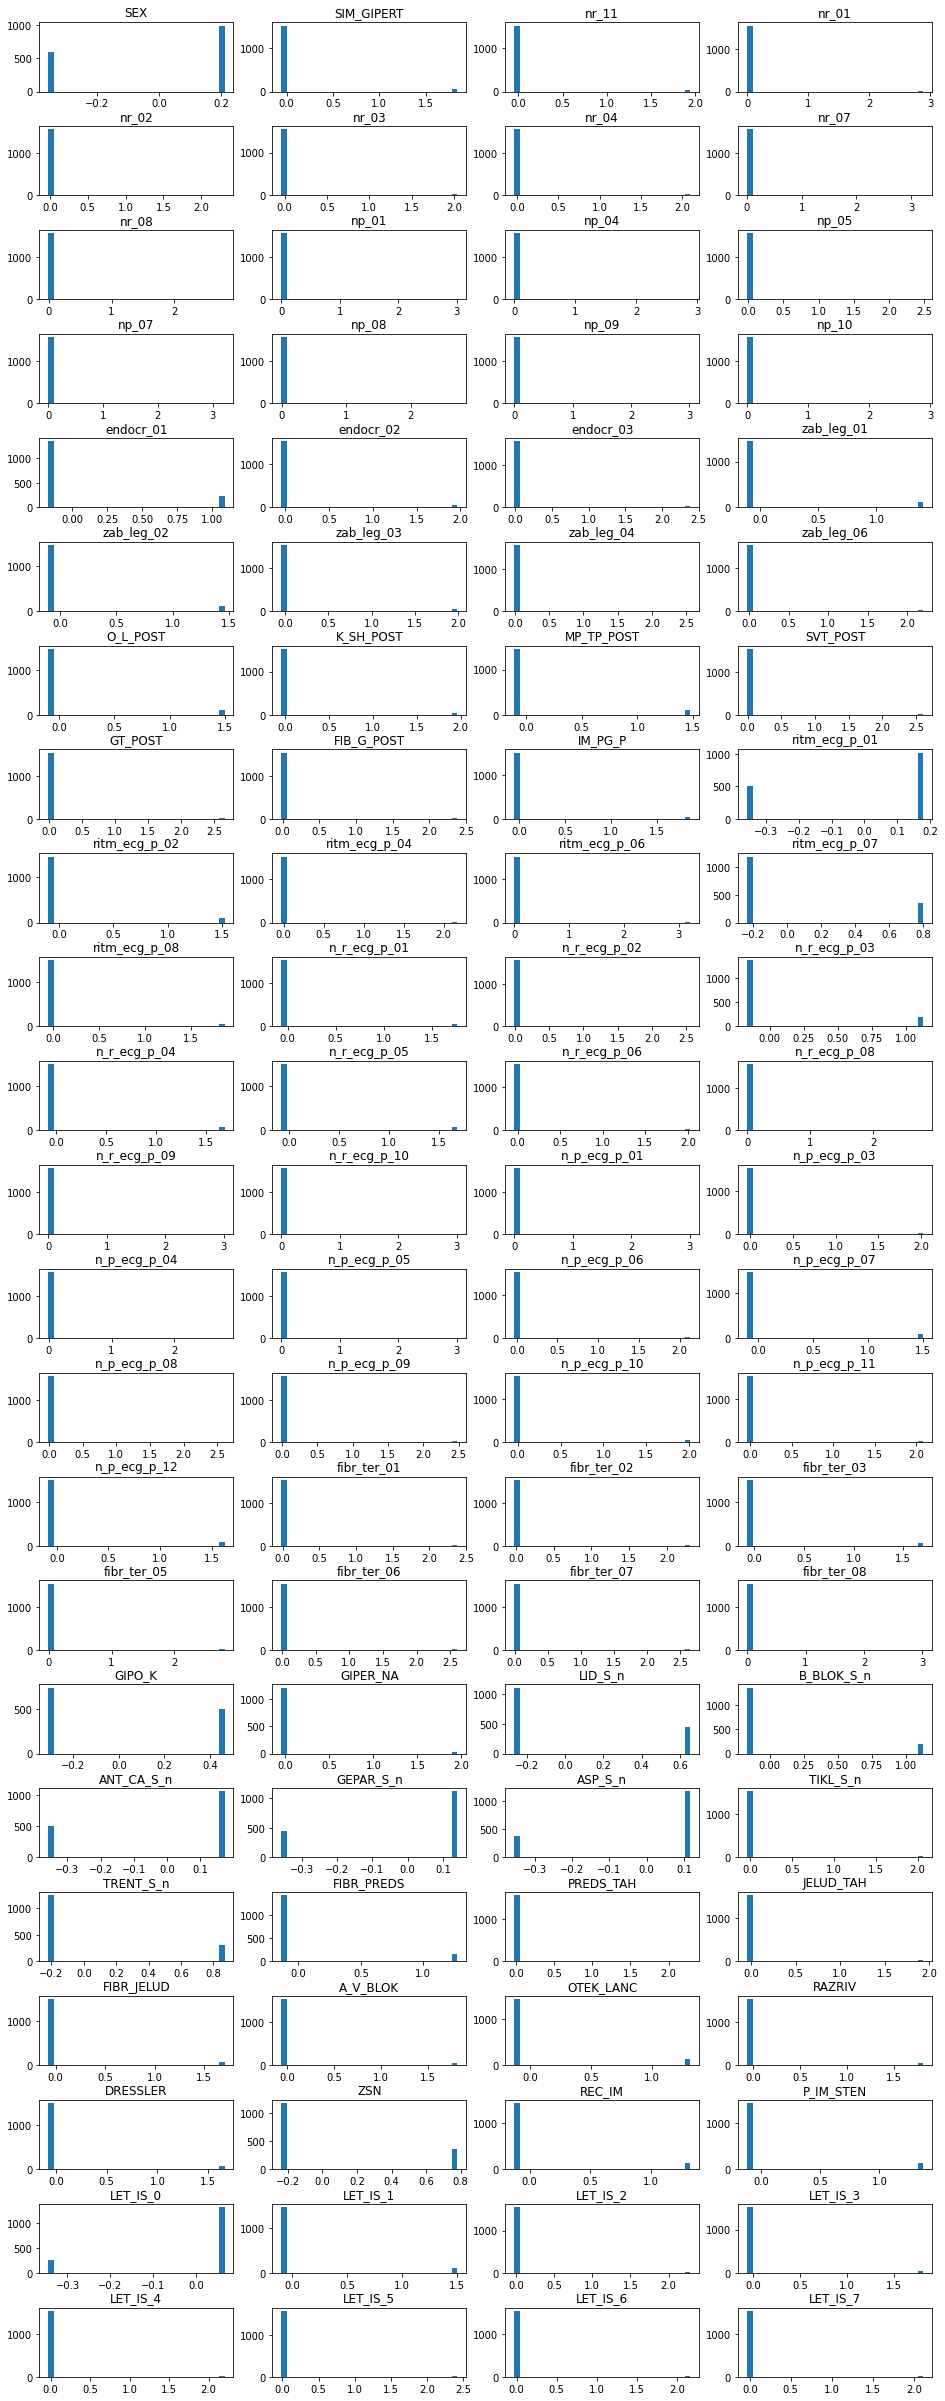

In [16]:
# univariate table quantification, check histograms for different variable types

import matplotlib.pyplot as plt

dframe = dfq

nbins = int(dframe.shape[0]/50)
var_type = 'CONTINUOUS'
var_type = 'ORDINAL'
var_type = 'BINARY'

ncont = variable_types.count(var_type)
plt.figure(figsize=(16,ncont/4*2))
plt.subplots_adjust(hspace=0.5,top=3)

k = 1
for i,v in enumerate(variable_types):
    if v==var_type:
        plt.subplot(ncont,4,k)
        col = dframe.columns[i+1]
        vals = dframe[col].to_numpy()
        plt.hist(vals,bins=nbins)
        plt.title(col)
        k = k+1


Matrix shape: (533, 123)
Effective linear dimension 24
Full matrix shape (1574, 123)


,ID,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,SIM_GIPERT,DLIT_AG,...,REC_IM,P_IM_STEN,LET_IS_0,LET_IS_1,LET_IS_2,LET_IS_3,LET_IS_4,LET_IS_5,LET_IS_6,LET_IS_7
0,1,1.352878,0.210873,1.303131,-0.021130,-0.200314,0.485205,1.232888,-0.059345,1.038212,...,-0.12977,-0.122575,0.066089,-0.101252,-0.024958,-0.063020,-0.02979,-0.018572,-0.032129,-0.035553
1,2,-0.585009,0.210873,0.630318,-0.743723,-0.834564,-0.870894,-0.887781,-0.059345,-0.884730,...,-0.12977,-0.122575,0.066089,-0.101252,-0.024958,-0.063020,-0.02979,-0.018572,-0.032129,-0.035553
2,3,-0.849266,0.210873,-0.534430,-0.743723,-0.834564,0.485205,0.350100,-0.059345,-0.095930,...,-0.12977,-0.122575,0.066089,-0.101252,-0.024958,-0.063020,-0.02979,-0.018572,-0.032129,-0.035553
3,4,0.560106,-0.355533,-0.534430,-0.743723,-0.834564,0.485205,0.350100,-0.059345,0.004838,...,-0.12977,-0.122575,0.066089,-0.101252,-0.024958,-0.063020,-0.02979,-0.018572,-0.032129,-0.035553
4,5,-0.144580,0.210873,-0.534430,-0.743723,-0.834564,0.485205,1.232888,-0.059345,1.038212,...,-0.12977,-0.122575,0.066089,-0.101252,-0.024958,-0.063020,-0.02979,-0.018572,-0.032129,-0.035553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1569,1695,1.352878,-0.355533,-0.534430,-0.743723,-0.834564,-0.870894,0.350100,-0.059345,1.038212,...,-0.12977,-0.122575,-0.345075,-0.101252,-0.024958,1.808563,-0.02979,-0.018572,-0.032129,-0.035553
1570,1696,1.352878,-0.355533,-0.534430,0.568705,0.510410,0.067104,0.350100,-0.059345,1.038212,...,-0.12977,-0.122575,-0.345075,-0.101252,-0.024958,1.808563,-0.02979,-0.018572,-0.032129,-0.035553
1571,1697,0.736278,-0.355533,-0.534430,0.887614,0.510410,0.067104,0.350100,-0.059345,1.038212,...,-0.12977,-0.122575,-0.345075,1.508559,-0.024958,-0.063020,-0.02979,-0.018572,-0.032129,-0.035553
1572,1699,1.529049,-0.355533,1.303131,0.201624,0.510410,0.067104,0.350100,-0.059345,1.038212,...,-0.12977,-0.122575,-0.345075,1.508559,-0.024958,-0.063020,-0.02979,-0.018572,-0.032129,-0.035553


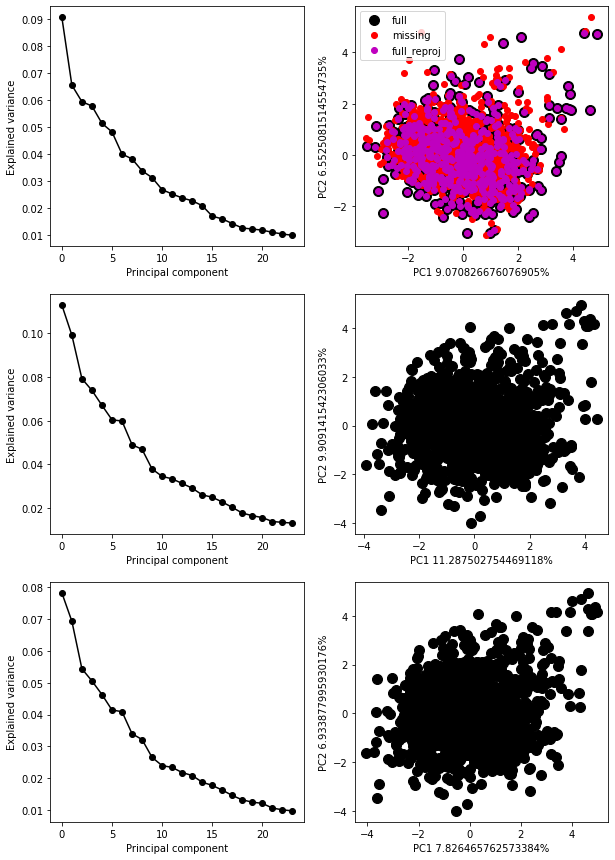

In [22]:
dfq_imputed = SVDcomplete_imputation_method(dfq, variable_types, verbose=True,num_components=-1)
display(dfq_imputed)

In [26]:
# saving the quantified and imputed file
#display(dfq_imputed)
dfq_imputed.round(3).to_csv(file[:-4]+'_q_imp_SVDcomplete.txt',index=False,sep='\t')

# saving the de-quantified imputed file
dequant_info = invert_quant_info(load_quantification_info(file[:-4]+'_norm_info.txt'))
#print(dequant_info)

df_imputed = dequantify_table(dfq_imputed,dequant_info)
#display(df_imputed)

df_imputed.to_csv(file[:-4]+'_imp_SVDcomplete.txt',index=False,sep='\t')